In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
n_images = 3000
img_size = 64

x = np.linspace(-5, 5, img_size)
X, Y = np.meshgrid(x,x)

images = torch.zeros(n_images,1,img_size,img_size)

for i in range(n_images):
  ro = 2 * np.random.randn(2) # ro = random offset
  width = np.random.rand() / .6 + 1.8 # random width
  G = np.exp(-((X-ro[0]) ** 2 + (Y-ro[1]) ** 2) /(2 * width ** 2)) 
  G = G + np.random.randn(img_size,img_size) / 5
  images[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)

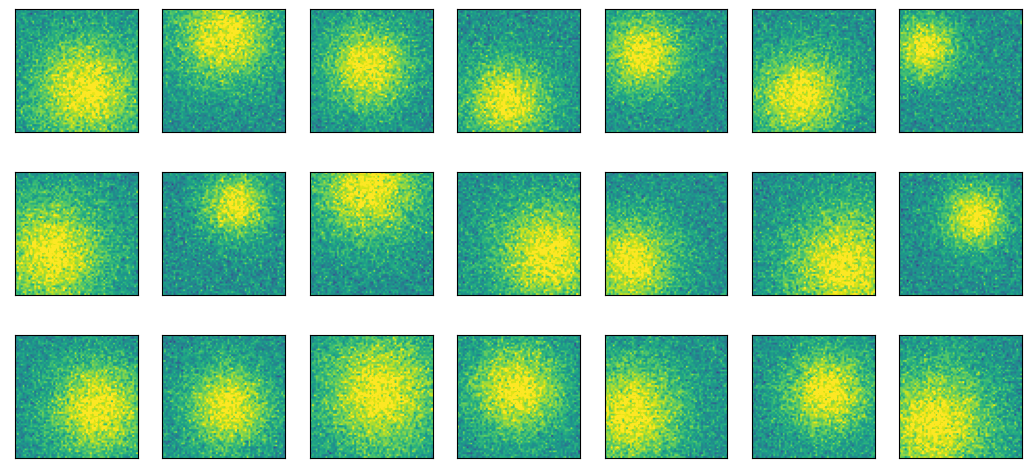

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(n_images)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)

        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
    
    def forward(self,x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.conv5(x))
        x = torch.sigmoid(x)
        return x.view(-1,1)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1)

        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.tanh(self.conv5(x))
        return x

In [7]:
loss_fun = nn.BCELoss()

discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=.0002)

In [13]:
EPOCHS = 2_000
batch_size = 64
losses = []
results_decision = []

for i in range(EPOCHS):
    r_idx = torch.randint(images.shape[0], (batch_size,))
    data = images[r_idx, :].to(device)

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    pred_real = discriminator(data)
    d_loss_real = loss_fun(pred_real, real_labels)

    fake_data = torch.randn(batch_size, 100, 1, 1).to(device)
    fake_images = generator(fake_data)
    pred_fake = discriminator(fake_images)
    d_loss_fake = loss_fun(pred_fake, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    fake_data = torch.randn(batch_size, 100, 1, 1).to(device)
    fake_images = generator(fake_data)
    pred_fake = discriminator(fake_images)

    g_loss = loss_fun(pred_fake, real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    losses.append([d_loss.item(), g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).detach().cpu()
    d2 = torch.mean((pred_real>.5).float()).detach().cpu()
    results_decision.append([d1,d2])

    if (i+1) % 100 == 0:
        print(f"Epoch: {i+1} of {EPOCHS} | d_loss: {d_loss} | g_loss: {g_loss}")

Epoch: 100 of 2000 | d_loss: 0.6797541379928589 | g_loss: 0.7598680257797241
Epoch: 200 of 2000 | d_loss: 0.6607767343521118 | g_loss: 0.7235037684440613
Epoch: 300 of 2000 | d_loss: 0.7283881902694702 | g_loss: 0.7441709041595459
Epoch: 400 of 2000 | d_loss: 0.6513171195983887 | g_loss: 0.7457590699195862
Epoch: 500 of 2000 | d_loss: 0.6771353483200073 | g_loss: 0.7635830640792847
Epoch: 600 of 2000 | d_loss: 1.0241210460662842 | g_loss: 0.8669830560684204
Epoch: 700 of 2000 | d_loss: 1.4413776397705078 | g_loss: 0.7696155309677124
Epoch: 800 of 2000 | d_loss: 1.4019148349761963 | g_loss: 0.7301900386810303
Epoch: 900 of 2000 | d_loss: 1.3889062404632568 | g_loss: 0.7288435101509094
Epoch: 1000 of 2000 | d_loss: 1.3884518146514893 | g_loss: 0.737826943397522
Epoch: 1100 of 2000 | d_loss: 1.0557422637939453 | g_loss: 0.6899287104606628
Epoch: 1200 of 2000 | d_loss: 0.7342411279678345 | g_loss: 0.7461483478546143
Epoch: 1300 of 2000 | d_loss: 0.6073840856552124 | g_loss: 0.7982436418533

In [14]:
losses = np.array(losses)
results_decision = np.array(results_decision)

In [15]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

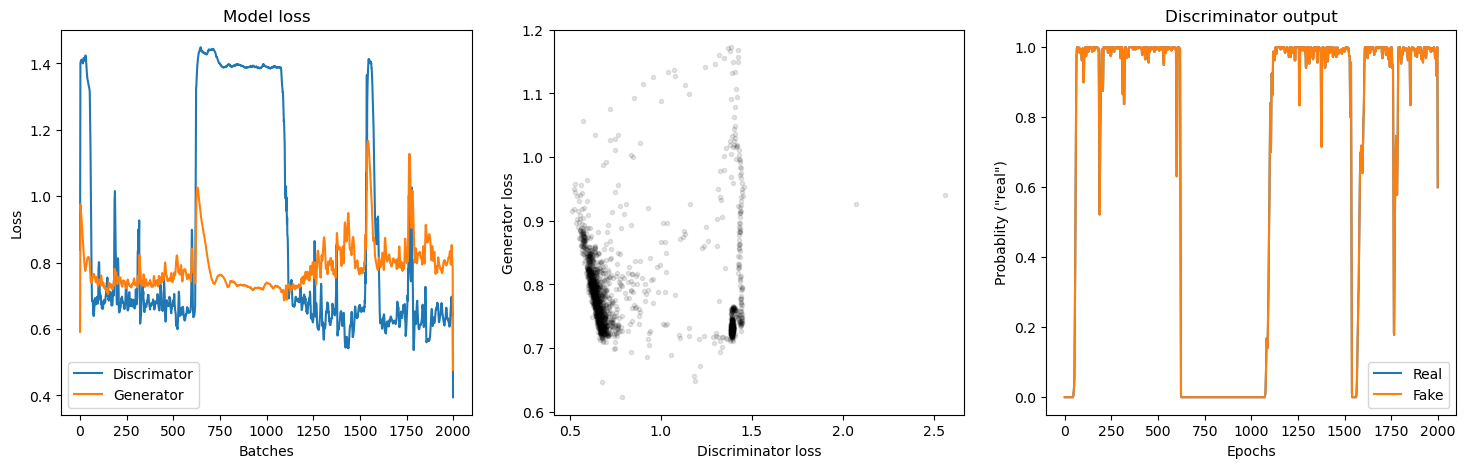

In [16]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(results_decision[:,0]))
ax[2].plot(smooth(results_decision[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

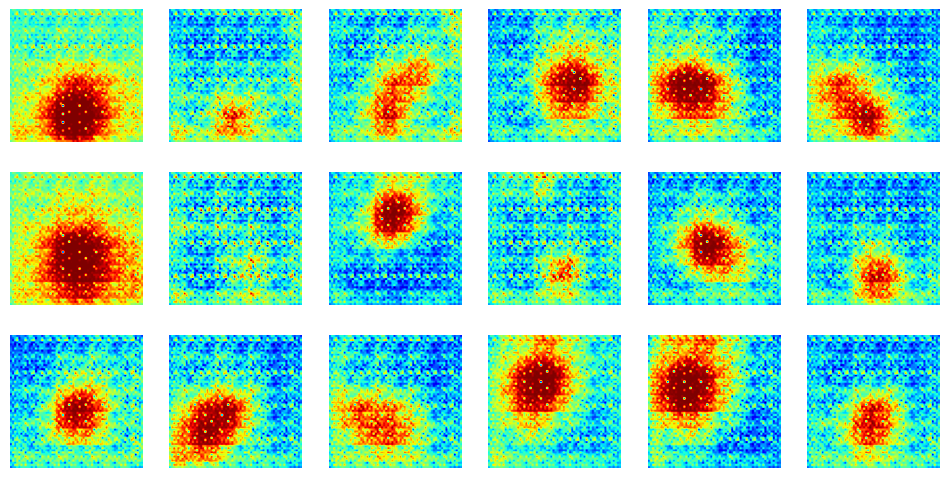

In [17]:
# generate the images from the generator network
generator.eval()
fake_data = generator( torch.randn(batch_size,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()